### Imports
Lots of these aren't necessary but I've copied and pasted it straight from the Explore gene.ipynb notebook.

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams['figure.dpi']=300 # dots per inch

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


In [4]:
BayesDel = pd.read_csv("./FH_mutations_BayesDel_Cleaned_2.csv")

In [5]:
# need to match column names to that of calculatedProperties
BayesDel.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

BayesDel.head()

,#chr,pos(1-based),ref,alt,genename,rs_dbSNP,AAfrom,AAto,Residue,HGVSc_VEP,HGVSp_VEP,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore
0,1,241497828,T,A,FH,.,X,C,511,c.1533A>T,p.Ter511CysextTer3,0.016367,-0.214267,0.53578
1,1,241497828,T,C,FH,.,X,W,511,c.1533A>G,p.Ter511TrpextTer3,0.048540,-0.168052,0.57861
2,1,241497828,T,G,FH,.,X,C,511,c.1533A>C,p.Ter511CysextTer3,0.019965,-0.209098,0.54067
3,1,241497829,C,A,FH,.,X,L,511,c.1532G>T,p.Ter511LeuextTer3,-0.136883,-0.434399,0.30031
4,1,241497829,C,G,FH,rs2147911168,X,S,511,c.1532G>C,p.Ter511SerextTer3,-0.148895,-0.451654,0.28133


In [6]:
# there's only some tables I want to keep
BayesDel = BayesDel[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","BayesDel_addAF_rankscore"]]

In [7]:
BayesDel_benign = BayesDel[BayesDel['BayesDel_noAF_score'] <= -0.057]
BayesDel_deleterious = BayesDel[BayesDel['BayesDel_noAF_score'] >= -0.057]

In [8]:
# converting tables to string to avoid potential errors
calculatedProperties = calculatedProperties.astype(str)
BayesDel_benign = BayesDel_benign.astype(str)
BayesDel_deleterious = BayesDel_deleterious.astype(str)

In [9]:
# merging datasets to get ready for binary classification
bs_calc = BayesDel_benign.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])
ds_calc = BayesDel_deleterious.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [10]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [11]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
0,L,V,507,0.125399,-0.0576501,0.66673,1.88196,2.48,2.18098,0.213414634,15.11647605,6.032148733,0,1
1,D,E,505,-0.0749932,-0.345499,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
2,D,E,505,-0.0749939,-0.3455,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
3,D,N,505,-0.00212996,-0.240836,0.51039,-0.211858,0.82,0.304071,0.63803681,18.71564022,10.63279724,0,1
4,K,N,504,-0.0242995,-0.272681,0.47907,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,F,I,50,0.206988,0.0595479,0.74357,2.2606,1.613,1.9368,0.538071066,20.36104043,31.8387706,1,0
2720,S,F,49,0.206421,0.0587329,0.74302,0.18208,4.837,2.50954,0.992307692,23.46114822,33.71310025,1,0
2721,S,C,49,0.194834,0.0420892,0.73211,0.0673518,7.99,4.0286759,0.992307692,23.46114822,33.71310025,1,0
2722,S,Y,49,0.211915,0.0666251,0.74823,0.474099,4.829,2.6515495,0.992307692,23.46114822,33.71310025,1,0


In [12]:
residue_minimum = logreg_data["Residue"].astype(int).min()
residue_maximum = logreg_data["Residue"].astype(int).max()

In [13]:
best_thresholds = []
best_aucs = []
residues = []
for residue in range(residue_minimum, residue_maximum+1):
    logreg_residue = logreg_data[logreg_data["Residue"].astype(float)==residue]
    
    logreg_y = logreg_residue[["source_deleterious"]]
    logreg_x = logreg_residue[["average_energy"]]
    
    logreg_x = logreg_x.astype(float)
    plotting_frame = pd.concat([logreg_x,logreg_y], axis=1)
    
    true_values = plotting_frame["source_deleterious"].to_list()
    
    # Check if true values contain both deleterious & benign, otherwise we'll get infinities
    if len(set(true_values)) < 2:
        continue # skip
        
    predlist = []
    roc_curvedata = []
    
    for i in np.arange(-5,20,0.1):
        pred = []
        for item in plotting_frame["average_energy"]:
            predvalue = 1 if item >= i else 0 # This line determines which group everything is in!
            pred.append(predvalue)
        predlist.append(pred)
        fpr, tpr, _ = roc_curve(true_values, pred)
        roc_auc = auc(fpr,tpr)
        curvelist = [i, fpr[1],tpr[1], roc_auc]
        roc_curvedata.append(curvelist)

    roc_dataframe = pd.DataFrame(roc_curvedata, columns = ["threshold","fpr","tpr","auc"])
    
    # Get the best AUC and corresponding threshold
    best_row = roc_dataframe.loc[roc_dataframe["auc"].idxmax()]
    best_thresholds.append(best_row["threshold"])
    best_aucs.append(best_row["auc"])
    residues.append(residue)

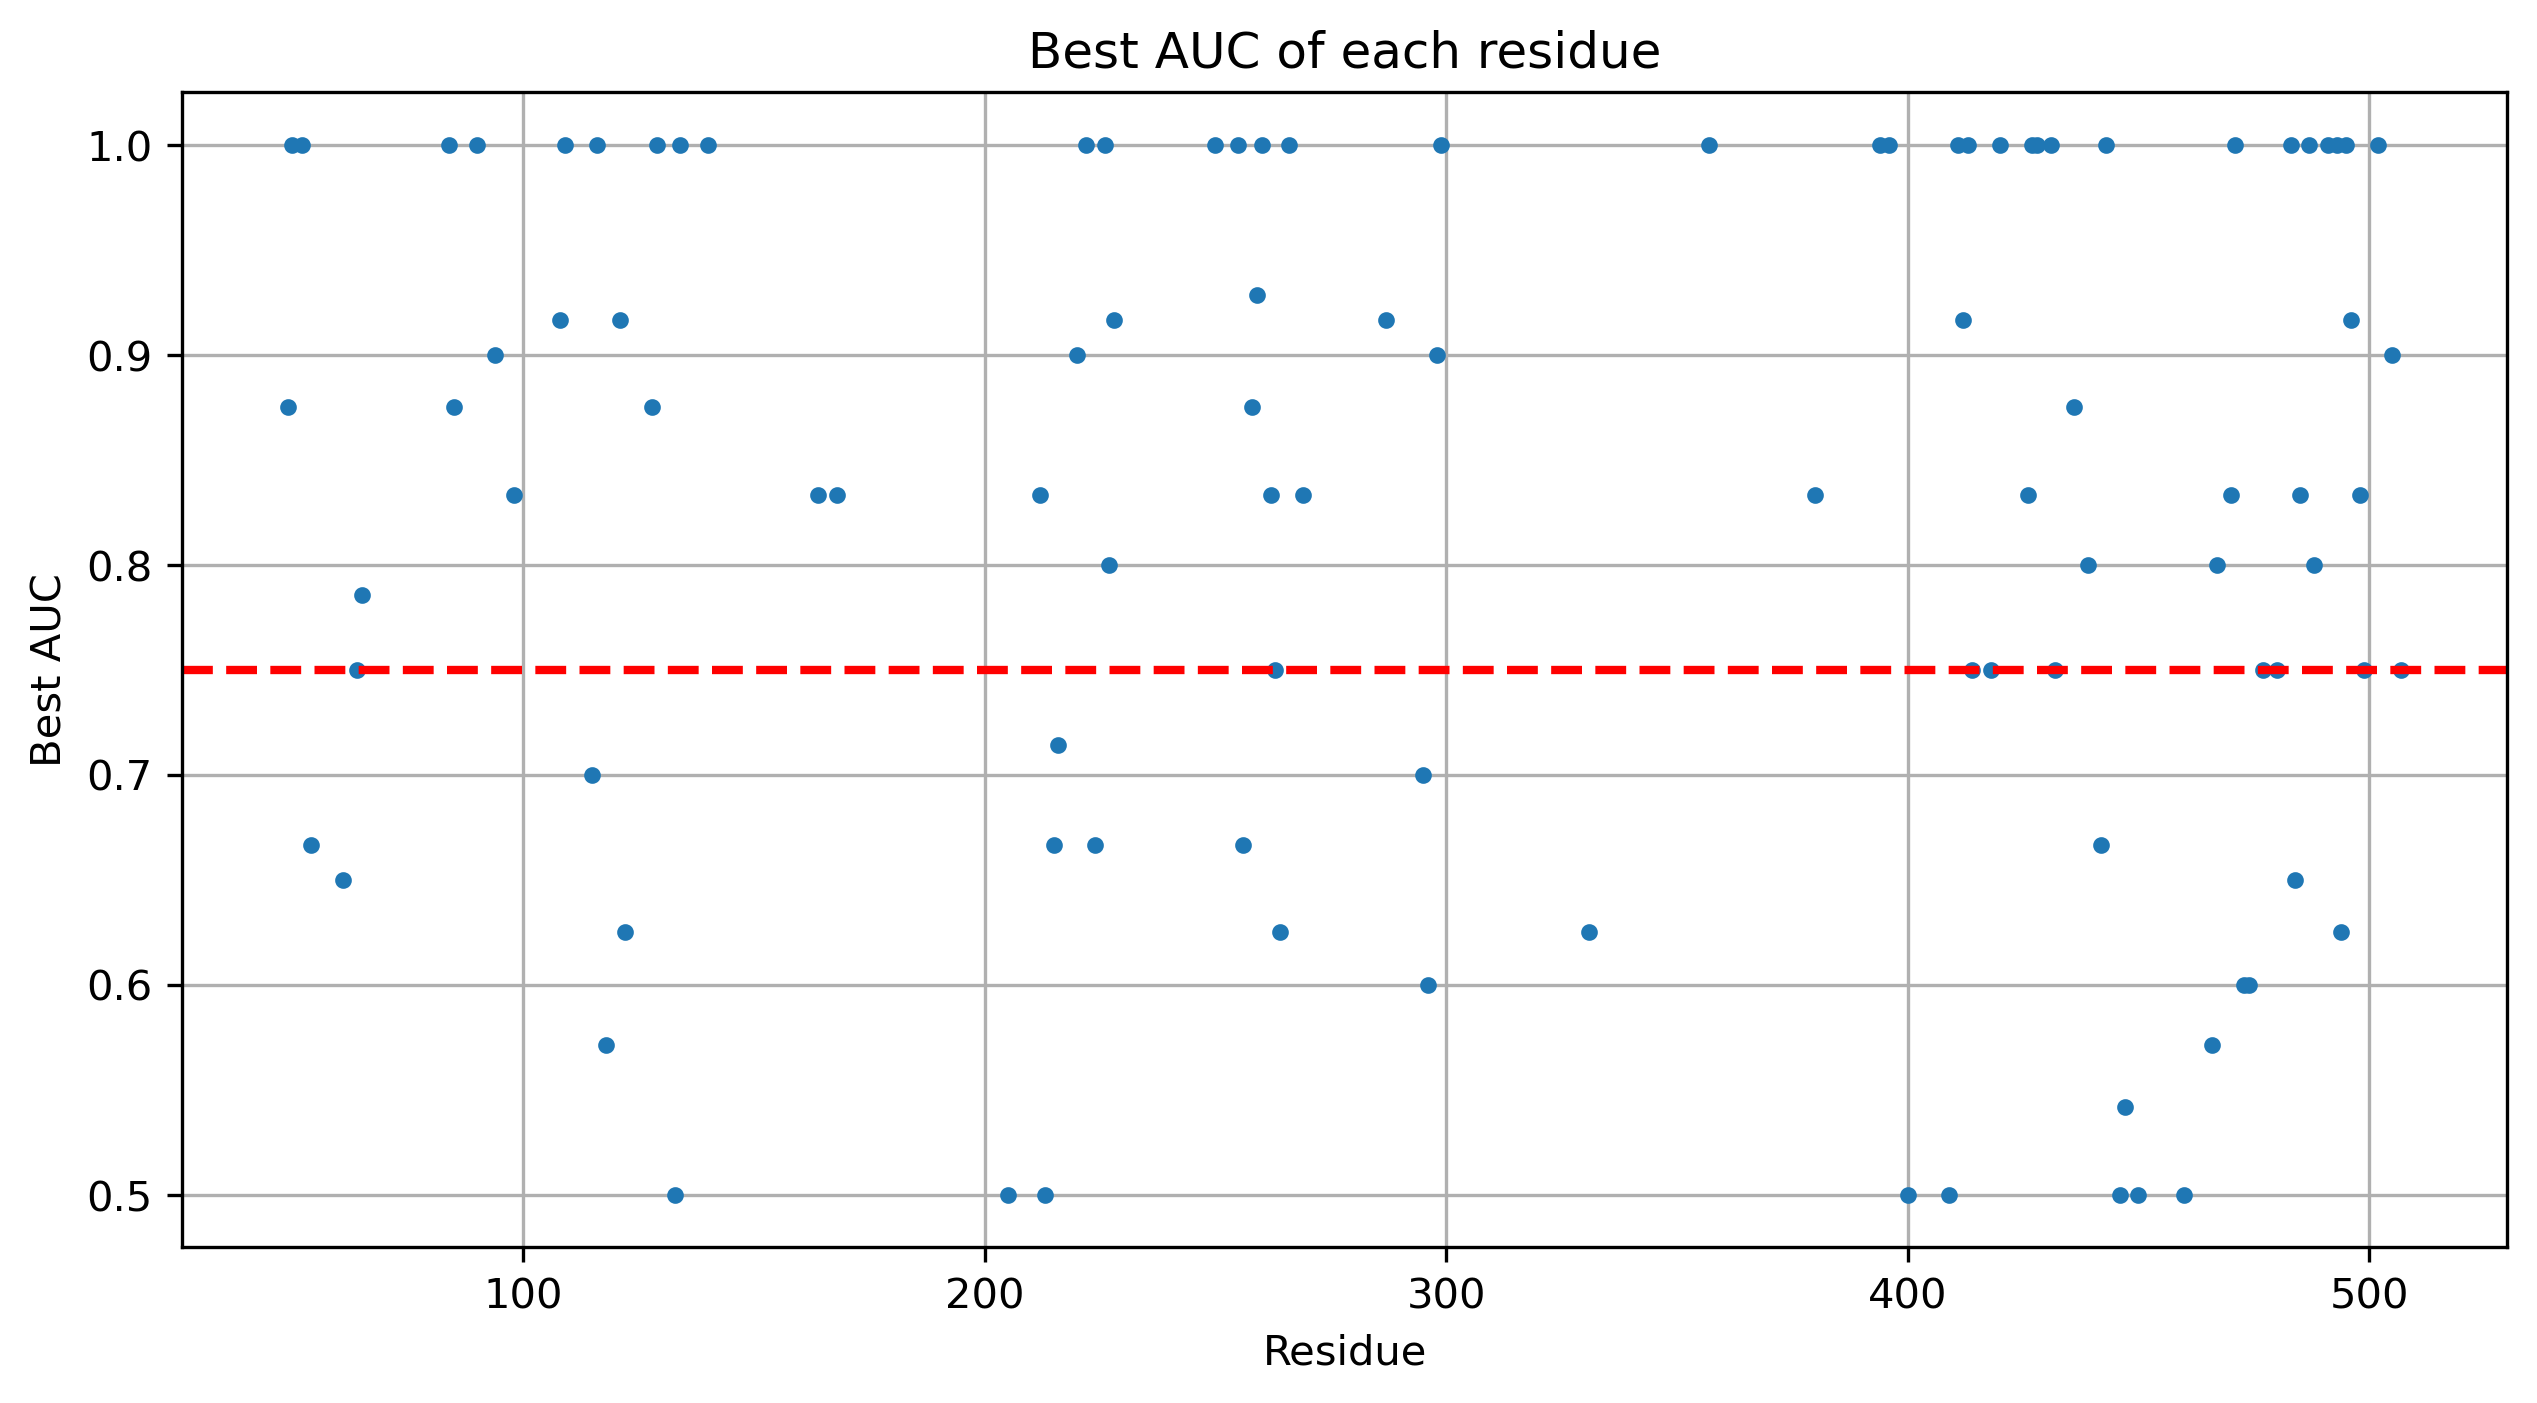

In [17]:
# Now plot using the filtered residues
plt.figure(figsize=(10, 5))
plt.plot(residues, best_aucs, '.')
# Cutoff horizontal line
plt.axhline(y=0.75, color="red", linestyle="--", linewidth=2)

# Labels and title
plt.xlabel("Residue")
plt.ylabel("Best AUC")
plt.title("Best AUC of each residue")
plt.grid()

# Show the plot
plt.show()

In [22]:
np.average(best_aucs)

0.82390289449113

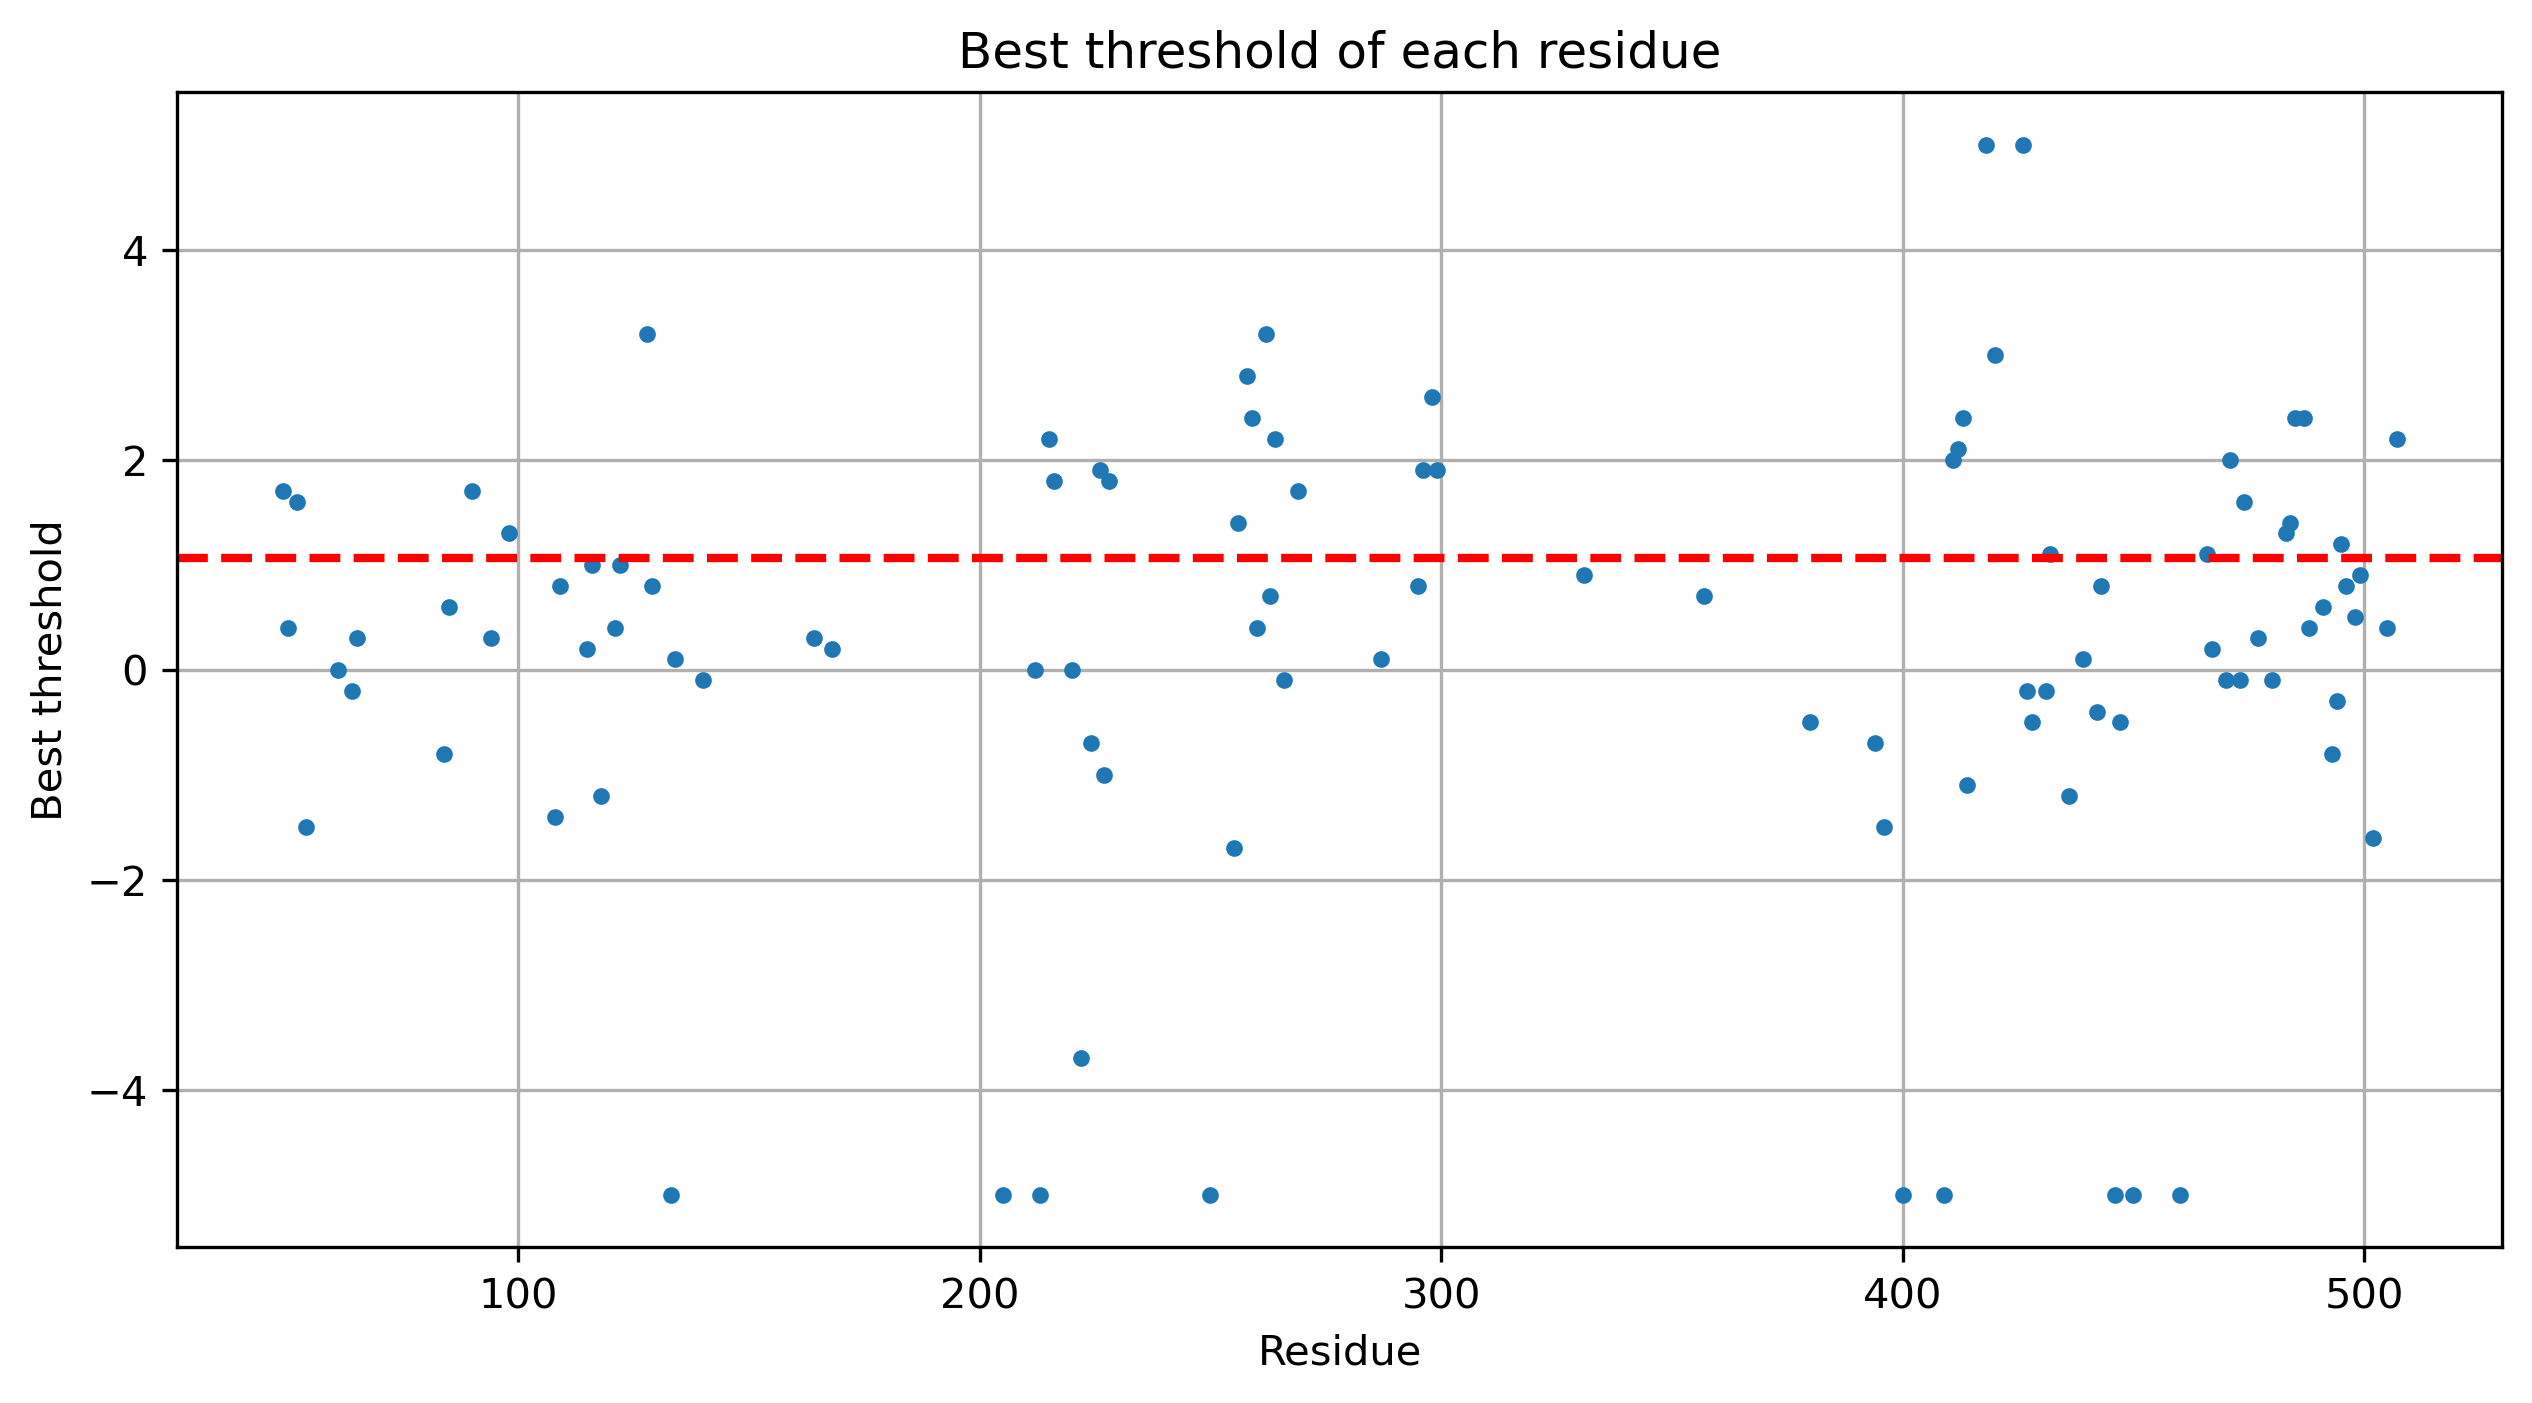

In [20]:
# Now plot using the filtered residues
plt.figure(figsize=(10, 5))
plt.plot(residues, best_thresholds, '.')
# Cutoff horizontal line
plt.axhline(y=1.06, color="red", linestyle="--", linewidth=2)

# Labels and title
plt.xlabel("Residue")
plt.ylabel("Best threshold")
plt.title("Best threshold of each residue")
plt.grid()

# Show the plot
plt.show()

In [23]:
np.average(best_thresholds)

0.20882352941174623